# <img src='./images/logo.svg' width=90 style="vertical-align:middle" /> SHAREing: High-level performance assessment notebook

This a template notebook for performing a high-level performance assessment, designed by the SHAREing consurtium. We see this notebook as a working document, where performance analysts can input measured data for a code, and use the markdown cells to make notes of their assessment.

## Software details (**in progress!**)

We recommend the analyst provide key pieces of information (which currently contains dummy info):
* Program name - **Tester**
* Parallel model (e.g., OpenMP, MPI, etc.) - **OpenMP**
* Compiler (including optimisation flags) - **gcc** with `-Ofast`
* Libraries/dependencies - `hdf5`
* Details on data input - using the `test_short.dat` configuration

## Report

In [1]:
from topics.core_table import core_perf
from topics.intra_node import intra_node_perf
from topics.inter_node import inter_node_perf
from topics.gpu_table import gpu_perf
from topics.io_table import io_perf
from topics.summary_radar import summary

### Core
For a high-level core analysis we just want 2 measurements for a serial code:

1. Maximum peak performance (Mflops/s)
2. Measured average peak FLOPS (Mflops/s)

**FLOPS** \
To measure these we use LIKWID, i.e., for FLOPS we use
```bash
likwid-bench -t peakflops -W S0:16kB:1
likwid-perfctr -f -C 0 -g FLOPS_DP ./my_exe
```
in which the input data for the `peakflops` microbenchmark is half the L1 cache. 

In [2]:
# Target peak per core (Mflops/s)
maximum_performance = 7255.60
# Measured average application peak (Mflops/s)
measured_performance = 241.1913

We read these values into our `core_perf` class

In [3]:
core_performance_stats = core_perf(maximum_performance, measured_performance)

Generate the **core performance** table below

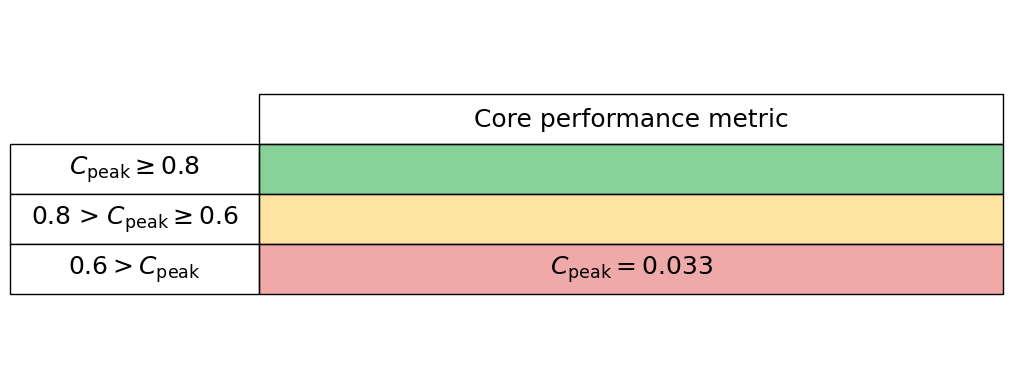

In [4]:
core_performance_stats.core_perf_table()

### Intra-node

To quantify intra-node performance at a high level we reply simply on runtimes under a strong scaling analysis.

**Serial run** \
If possible, we first measure the runtime of a serial application without any parallel libraries, e.g., compile without the `-fopenmp` flag. This can seem redundant but allows us to see the overhead of the parallel library when compared to a single-core run including the parallel library. 

If the parallel library cannot be switched off simply, then we suggest just setting the serial runtime equal to a single-core (with parallel library enabled) runtime.

**Strong scaling** \
We now perform a strong scaling analysis by keeping our problem sized fixed but increasing the core count up to the maximum for your hardware. For an OpenMP code the thread number can be set simply with the `OMP_NUM_THREADS` environment variable, however, with this method thread affinity can be an issue. It can make performance variable relative to a thread pinned run.

Thread pinning can be easily acheived by setting the `OMP_PROC_BIND` environment variable to `close`, however, we again make use of LIKWID
```bash
likwid-pin -c N:0-3 ./my_exe
```
This command can be nested into a for loop to increase the core count to efficiently perform a strong scaling analysis.

**Input data** \
In the cell below we ask for the:
1. Serial runtime
2. A list of the core numbers used for the strong scaling
3. A list of the relative runtime per number of cores

The core count and runtimes are currently just setup with dummy data as lists. For significant strong scaling analyses, it can be quicker to save these data to a `*.csv` file and read these into lists rather than inputting values by hand.

In [5]:
# Enter serial performance time (s)
serial_time = 162.22

# enter number of cores in each trial
number_of_cores = [1, 2, 3, 4, 6, 8, 12, 16]

# Enter time for each number of cores (s)
time = [162.22, # 1 core
        55.61, # 2 core
        42.85, # 3 core
        35.35, # 4 core
        30.82, # 6 core
        24.45, # 8 core
        21.93, # 12 core
        19.72 # 16 core
       ]

We read these values into our `intra_node_perf` class

In [6]:
intra_node_stats= intra_node_perf(serial_time, number_of_cores, time)

Generate the intra-node **parallel efficiency** plot below, including amber and red vertical lines which indicate the core counts below which the parallel efficiency drops to 80% and 60%, respectively.

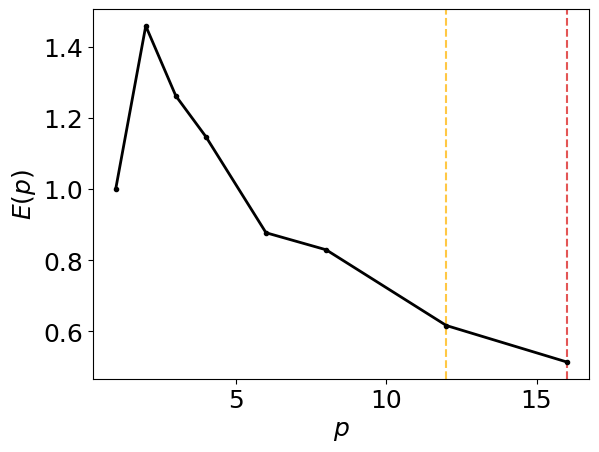

In [7]:
intra_node_stats.parallel_efficiency_figure()

Generate the intra-node **runtimes** plot below

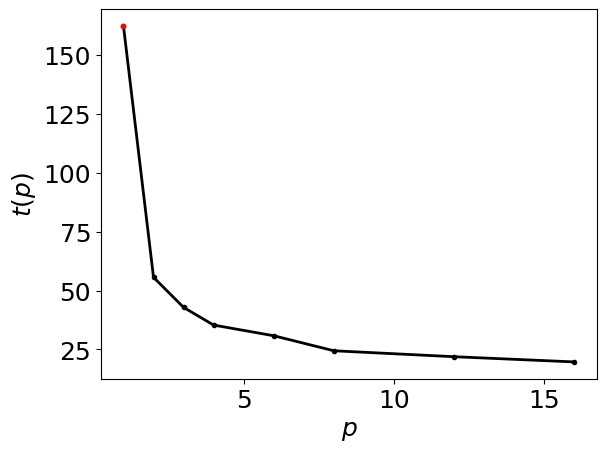

In [8]:
intra_node_stats.runtimes_figure()

Generate the **intra-node** performance table below

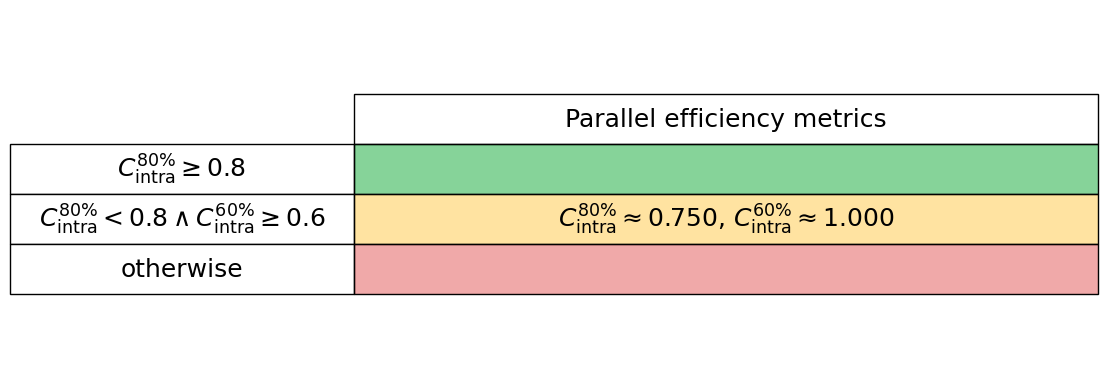

In [9]:
intra_node_stats.intra_node_perf_table()

### Inter-node

To quantify intra-node performance at a high level we reply simply on runtimes under a weak scaling analysis.

**Weak scaling** \
To perform a weak scaling we run our executable across several number of nodes, e.g., 1, 2, 4, etc. For the problem size executed on 1 node we then need to scale up the problem for each run, i.e., double the problem size across for 2 nodes such that the problem size on each node remains approximately constant. 

**Input data** \
In the cell below we ask for the:
1. A list of the node counts used for the weak scaling
2. A list of the relative runtime per number of nodes

The node count and runtimes are currently just setup with dummy data as lists. For significant weak scaling analyses, it can be quicker to save these data to a `*.csv` file and read these into lists rather than inputting values by hand.

----------------
#### TODO 

**Weak scaling (with LIKWID)** \
We simply increase the problem size with node count, i.e., double the nodes means double the problem size. Inter-node codes will depend on MPI as the communication library. In the intra-node case we had to be careful of *thread affinity* in the inter-node case we may suffer from low *rank affinity*. Once again LIKWID offers us tools to pin MPI ranks to physical nodes, and we recommend this workflow as performance results are more standardised and reliable.

```bash
likwid-mpirun -h
```
...


In [10]:
# Enter serial performance time (s)
inter_node_serial_time = 162.22

# enter number of cores in each trial
node_count = [1, 2, 4, 6, 8, 12, 16]

# Enter time for each number of cores (s)
inter_node_runtimes = [162.22, 160.0, 180.0, 200.0, 280.0, 220.0, 300.0]

We read these values into our `inter_node_perf` class

In [11]:
inter_node_statistics = inter_node_perf(inter_node_serial_time, node_count, inter_node_runtimes)

Generate the inter-node **parallel efficiency** plot below, including amber and red vertical lines which indicate the core counts below which the parallel efficiency drops to 80% and 60%, respectively.

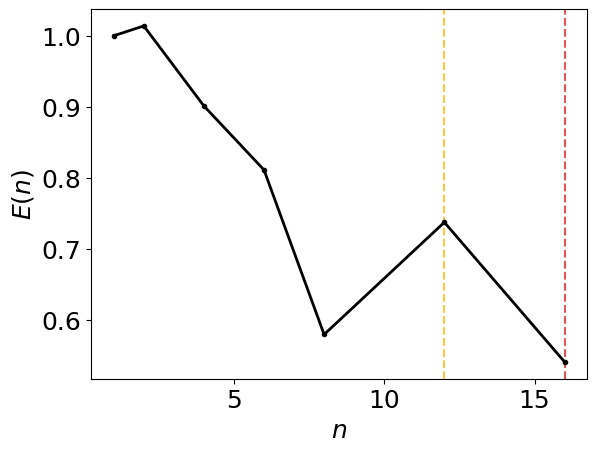

In [12]:
inter_node_statistics.parallel_efficiency_figure()

Generate the inter-node **runtimes** plot below

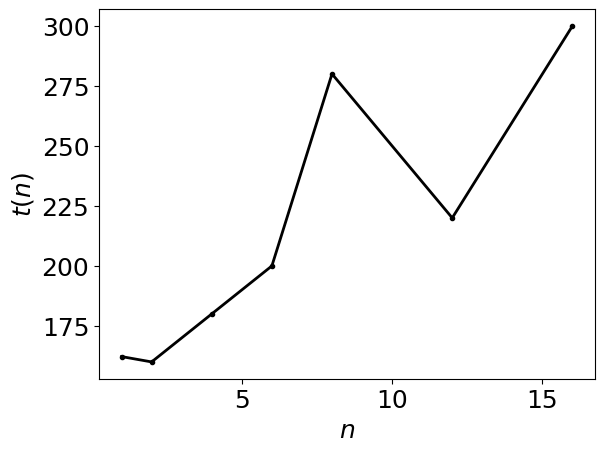

In [13]:
inter_node_statistics.runtimes_figure()

Generate the **intra-node** performance table below

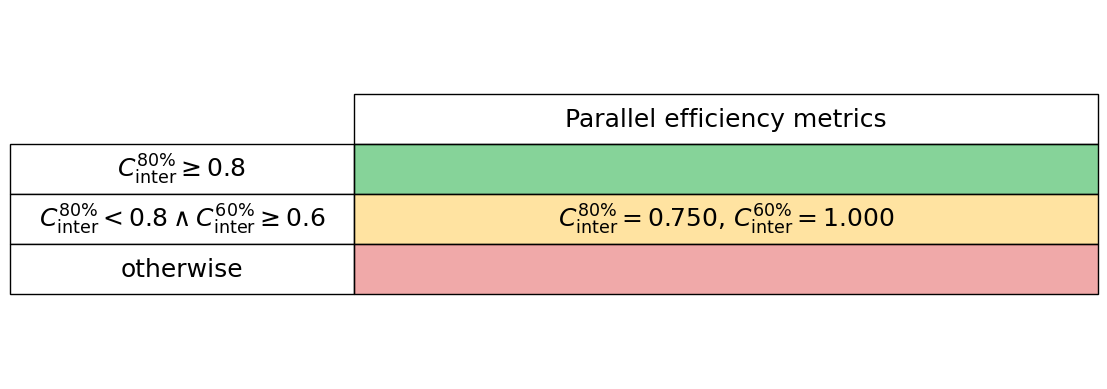

In [14]:
inter_node_statistics.inter_node_perf_table()

### GPU

To quantify GPU performance at a high level we use two metrics:
1. GPU utilisation or occupancy
2. GPU memory usage

**GPU utilisation or occupancy** \
This metric is typically a measure of the proportion of computational resources in use by the code. In Nvidia language this will likely be the proportion of streaming multiprocessors in use. We simply read this metric into our `gpu_perf` class below, and most GPU vendor's tools will give this high-level metric for their hardware.

**GPU memory usage** \
We compute the proportion of the maximum memory footprint used by the software by reading the theoretical `gpu_peak_memory` (typically from the vendor's data sheets) and measure the actual memory usage, `gpu_measured_memory`, which again is typically given from most vendor tools.

In [15]:
gpu_utilisation = 0.82

We read these values into our `gpu_perf` class

In [16]:
gpu_perf_statistics = gpu_perf(gpu_utilisation)

Generate the **GPU performance** table below

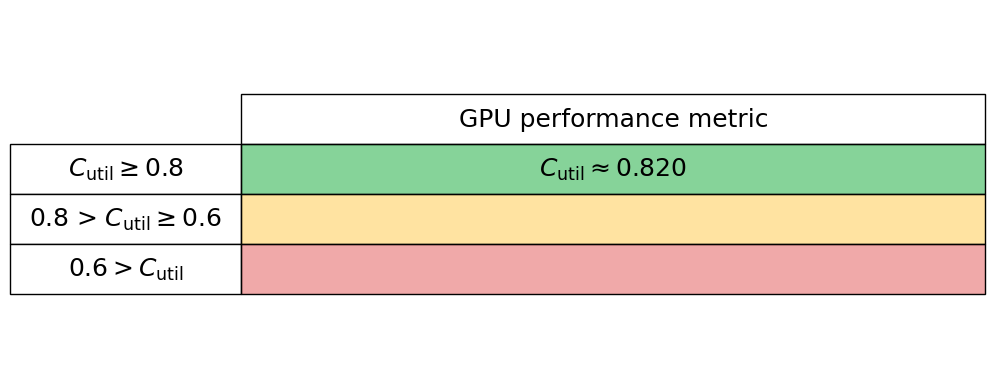

In [17]:
gpu_perf_statistics.gpu_perf_table()

### I/O

To quantify I/O (Input/Output) performance at a high level we simply ask what proportion of an applications total runtime is spent in read and writes. Many performance tools can give these high-level metrics, e.g., Intel VTune and Linaro Performance Reports. Typically these measures are given for both reads and writes separately, so we here read these two proportions in independently, thus the performance is charactertised by $C_{\mathrm{I/O}} = 1 - (C_{\mathrm{read}} + C_{\mathrm{write}})$. Therefore a low $C_{\mathrm{I/O}}$ value implies that the application is spending significant time in reading and writing to disk. 

In [18]:
read_proportion = 0.1
write_proportion = 0.25

We read these values into our `io_perf` class

In [19]:
io_statistics = io_perf(read_proportion, write_proportion)

Generate the **I/O performance** table below

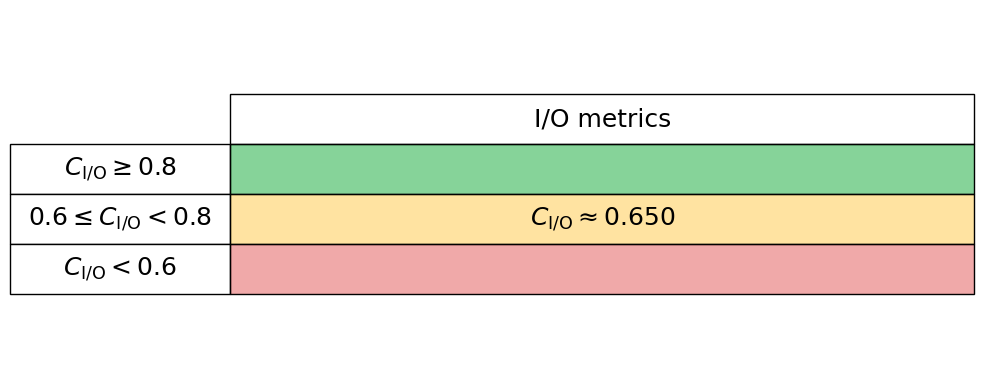

In [20]:
io_statistics.io_perf_table()

### Summary diagram (radar plot) - **In Progress!**

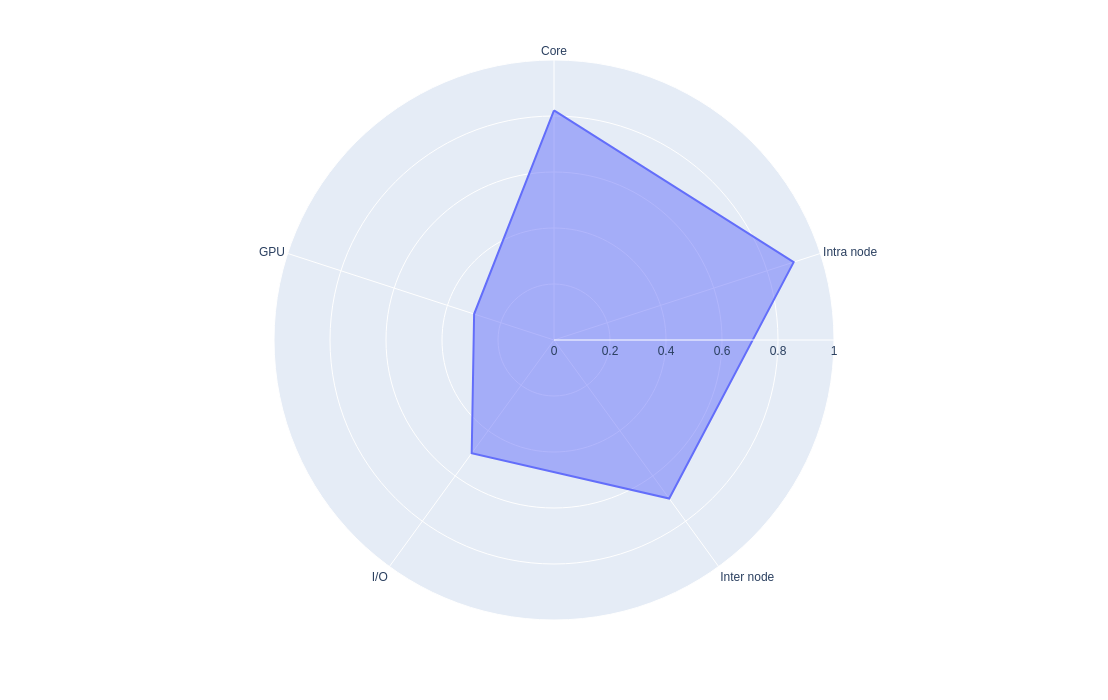

In [22]:
summary_statistics = summary(core_performance_stats, intra_node_stats)
summary_statistics.draw_radar()

This project has received funding through the UKRI Digital Research Infrastructure Programme under grant UKRI1801 (SHAREing)

<img src='./images/ukri.png' width=200 style="vertical-align:middle" /> 